<a href="https://colab.research.google.com/github/kap2403/Image-Classification-between-Dogs-and-Cats-in-PyTorch./blob/main/updated_of_spatial_transform_unet_cam2bev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import torch
import torchvision.models as models
from tqdm import tqdm
import json
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import math
import itertools
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def resize_image(img, shape, interpolation=cv2.INTER_CUBIC):
    # resize relevant image axis to length of corresponding target axis while preserving aspect ratio
    axis = 0 if float(shape[0]) / float(img.shape[0]) > float(shape[1]) / float(img.shape[1]) else 1
    factor = float(shape[axis]) / float(img.shape[axis])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor, interpolation=interpolation)

    # crop other image axis to match target shape
    center = img.shape[int(not axis)] / 2.0
    step = shape[int(not axis)] / 2.0
    left = int(center-step)
    right = int(center+step)
    if axis == 0:
        img = img[:, left:right]
    else:
        img = img[left:right, :]

    return img

In [3]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self,front_image_dir,bev_image_dir,transform=None, target_transform=None):
        self.front_image_dir=front_image_dir
        self.bev_image_dir=bev_image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.front_images_path=list()
        self.bev_images_path=list()
        for i in tqdm(os.listdir(self.front_image_dir)):
            self.front_images_path.append(os.path.join(self.front_image_dir,i))
            self.bev_images_path.append(os.path.join(self.bev_image_dir,i))
            
    def __len__(self):
        return len(self.bev_images_path)

    def __getitem__(self, idx):
        dim = (512,512)
        img = cv2.cvtColor(cv2.imread(self.front_images_path[idx]), cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img,dim)
        #image = torch.tensor(img)
        image = self.transform(img)
        bev_image = cv2.cvtColor(cv2.imread(self.bev_images_path[idx]), cv2.COLOR_BGR2RGB)
        #bev_image = cv2.resize(bev_image,dim)
        #bev_image = torch.tensor(bev_image)
        bev_image = self.transform(bev_image)
        bev_image = bev_image*255
        image = image*255
        return image.to(torch.int64), bev_image.to(torch.int64)

In [4]:
train_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((512,512)),
  #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
front_image='/content/drive/MyDrive/front'
bev_occulsion='/content/drive/MyDrive/bev+occlusion'
dataset=CustomImageDataset(front_image,bev_occulsion,transform = train_transforms)

100%|██████████| 3172/3172 [00:00<00:00, 188601.57it/s]


In [7]:
train_set , validation_set , test_Set = torch.utils.data.random_split(dataset, [172,1000,2000])

In [8]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = 1, shuffle = True, num_workers = 0)

validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size = 1, shuffle = True, num_workers = 0)

test_loader=torch.utils.data.DataLoader(
    test_Set, batch_size = 1, shuffle = True, num_workers = 0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cuda')

In [11]:
for i,j in train_loader:
    print(i.shape)
    #print(i[0])
    #plt.imshow(i[0].permute(1,2,0))
    break

torch.Size([1, 3, 512, 512])


In [12]:
device = torch.device('cuda' if torch.cuda.is_available else "cpu")

In [13]:
class Camera_parameters():
    def __init__(self):
        super(Camera_parameters, self).__init__()
        
    def rotation_from_euler(self,roll=1., pitch=1., yaw=1.):
        """
        Get rotation matrix
        Args:
            roll, pitch, yaw:       In radians
        Returns:
            R:          [4, 4]
        """
        si, sj, sk = np.sin(roll), np.sin(pitch), np.sin(yaw)
        ci, cj, ck = np.cos(roll), np.cos(pitch), np.cos(yaw)
        cc, cs = ci * ck, ci * sk
        sc, ss = si * ck, si * sk

        R = np.identity(4)
        R[0, 0] = cj * ck
        R[0, 1] = sj * sc - cs
        R[0, 2] = sj * cc + ss
        R[1, 0] = cj * sk
        R[1, 1] = sj * ss + cc
        R[1, 2] = sj * cs - sc
        R[2, 0] = -sj
        R[2, 1] = cj * si
        R[2, 2] = cj * ci
        return R

    def translation_matrix(self,vector):
        """
        Translation matrix
        Args:
            vector list[float]:     (x, y, z)
        Returns:
            T:      [4, 4]
        """
        M = np.identity(4)
        M[:3, 3] = vector[:3]
        return M

    def load_camera_params(self,file):
        """
        Get the intrinsic and extrinsic parameters
        Returns:
            Camera extrinsic and intrinsic matrices
        """
        with open(file, 'rt') as handle:
            p = json.load(handle)

        fx, fy = p['fx'], p['fy']
        u0, v0 = p['u0'], p['v0']

        pitch, roll, yaw = p['pitch'], p['roll'], p['yaw']
        x, y, z = p['x'], p['y'], p['z']

        # Intrinsic
        K = np.array([[fx, 0, u0, 0],
                      [0, fy, v0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

        # Extrinsic
        R_veh2cam = np.transpose(self.rotation_from_euler(roll, pitch, yaw))
        T_veh2cam = self.translation_matrix((-x, -y, -z))

        # Rotate to camera coordinates
        R = np.array([[0., -1., 0., 0.],
                      [0., 0., -1., 0.],
                      [1., 0., 0., 0.],
                      [0., 0., 0., 1.]])

        RT = R @ R_veh2cam @ T_veh2cam
        return RT, K

In [14]:

class BilinearInterpolation(nn.Module):
    def __init__(self):
        super(BilinearInterpolation, self).__init__()
        self.camera = Camera_parameters()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        
    def bilinear_sampler(self,imgs, pix_coords):

        batch_Size, img_h, img_w ,img_c= imgs.shape
        pix_h, pix_w,pix_c = pix_coords.shape
        out_shape = (pix_h, pix_w,img_c)

        pix_x, pix_y = np.split(pix_coords, [1], axis=-1)  # [pix_h, pix_w, 1]
        pix_x = pix_x.to(torch.float32)
        pix_y = pix_y.to(torch.float32)

        # Rounding
        pix_x0 = torch.floor(pix_x)
        pix_x1 = pix_x0 + 1
        pix_y0 = torch.floor(pix_y)
        pix_y1 = pix_y0 + 1

        # Clip within image boundary
        y_max =  torch.tensor(img_h - 1).to(device=device)
        x_max =  torch.tensor(img_w - 1).to(device=device)
        zero = torch.zeros([1]).to(device=device)

        pix_x0 = torch.clamp(pix_x0, zero, x_max).to(device=device)
        pix_y0 = torch.clamp(pix_y0, zero, y_max).to(device=device)
        pix_x1 = torch.clamp(pix_x1, zero, x_max).to(device=device)
        pix_y1 = torch.clamp(pix_y1, zero, y_max).to(device=device)

        # Weights [pix_h, pix_w, 1]
        wt_x0 = (pix_x1 - pix_x).to(device=device)
        wt_x1 = (pix_x - pix_x0).to(device=device)
        wt_y0 = (pix_y1 - pix_y).to(device=device)
        wt_y1 = (pix_y - pix_y0).to(device=device)

        # indices in the image to sample from
        dim = img_w

        # Apply the lower and upper bound pix coord
        base_y0 = (pix_y0 * dim).to(device=device)
        base_y1 = (pix_y1 * dim).to(device=device)

        # 4 corner vertices
        idx00 = (pix_x0 + base_y0).flatten().to(torch.int).to(device=device) 
        idx01 = (pix_x0 + base_y1).to(torch.int).to(device=device) 
        idx10 = (pix_x1 + base_y0).to(torch.int).to(device=device) 
        idx11 = (pix_x1 + base_y1).to(torch.int).to(device=device) 
        # Gather pixels from image using vertices
        imgs_flat = imgs.reshape([-1, img_c]).to(torch.float64).to(device=device) 
        im00 = imgs_flat[idx00.to(torch.long)].reshape(out_shape).to(device=device) 
        im01 = imgs_flat[idx01.to(torch.long)].reshape(out_shape).to(device=device) 
        im10 = imgs_flat[idx10.to(torch.long)].reshape(out_shape).to(device=device) 
        im11 = imgs_flat[idx11.to(torch.long)].reshape(out_shape).to(device=device) 

        w00 = wt_x0 * wt_y0.to(device=device) 
        w01 = wt_x0 * wt_y1.to(device=device) 
        w10 = wt_x1 * wt_y0.to(device=device) 
        w11 = wt_x1 * wt_y1.to(device=device) 
        output = w00 * im00 + w01 * im01 + w10 * im10 + w11 * im11
        return output.to(device=device) 
    
    
    def perspective(self,cam_coords, proj_mat, h, w):
        eps = 1e-7
        pix_coords = proj_mat @ cam_coords
        pix_coords = pix_coords[:2, :] / (pix_coords[2, :] + eps)
        pix_coords = np.reshape(pix_coords, (2, h, w))
        pix_coords = np.transpose(pix_coords, (1, 2, 0))
        pix_coords = torch.from_numpy(pix_coords)
        return pix_coords.to(device=device) 
    
    def ipm_from_parameters(self,image, xyz, K, RT, TARGET_H, TARGET_W,interpolation_fn):

        xyz[1] = -xyz[1]
        P = K @ RT
        pixel_coords = self.perspective(xyz, P,TARGET_H, TARGET_W)
        image2 = interpolation_fn(image, pixel_coords)
        return image2.to(torch.int64).to(device=device)
    
    def meshgrid(self, xmin, xmax, num_x, ymin, ymax, num_y, is_homogeneous=True):
        """
        Grid is parallel to z-axis
        Returns:
            array x,y,z,[1] coordinate   [3/4, num_x * num_y]
        """
        x = np.linspace(xmin, xmax, num_x)
        y = np.linspace(ymin, ymax, num_y)
        x, y = np.meshgrid(x, y)
        x = x.flatten()
        y = y.flatten()
        z = np.zeros_like(x)

        if is_homogeneous:
            coords = np.stack([x, y, z, np.ones_like(x)], axis=0)
        else:
            coords = np.stack([x, y, z], axis=0)
        return coords#.to(device=device) 
    


    def plane(self, x, y, z, roll, pitch, yaw, col, row, scale):
        """
        Returns:
            Grid coordinate: [b, 3/4, row*cols]
        """
        xmin = x
        xmax = x + col * scale
        ymin = y
        ymax = y + row * scale
        return self.meshgrid(xmin, xmax, col,
                        ymin, ymax, row)


    def forward(self,image,file,x,y,scale):
        batch_size, TARGET_H,TARGET_W,channels = image.shape
        plane = self.plane(x,y, 0, 0, 0, 0, TARGET_H, TARGET_W, scale)
        extrinsic, intrinsic = self.camera.load_camera_params(file)
        warped1 = self.ipm_from_parameters(image, plane, intrinsic, extrinsic,TARGET_H, TARGET_W, self.bilinear_sampler) 
        #out = torch.unsqueeze(warped1.to(torch.int64), 0).permute(0,3,1,2)
        out = torch.unsqueeze(warped1, 0).to(torch.int64).permute(0,3,1,2)
        #out = self.conv1(out)
        return out

In [16]:

model = BilinearInterpolation()
for batch_idx, (data, target) in enumerate(train_loader):
    data = data.permute(0,2,3,1)
    out = model(data,'/content/sample_data/untitled512.json',10,-26,0.1) # convert to torch.float32
    #np.clip((outputs[0]  .squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255),0, 255).astype(np.uint8).copy(order='C')

    plt.imshow((out[0].permute(1,2,0).detach().cpu().numpy()),0, 255).copy(order='C')
    break

FileNotFoundError: ignored

# New Section

In [17]:
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=16):
        super(UNet, self).__init__()
        features = init_features
        self.STN = BilinearInterpolation()
        self.dropout = nn.Dropout(p=0.1)
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder5 = UNet._block(features * 8, features * 16, name="enc5")
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.joiner1 = UNet._block(features*1,features*1,name = 'joiner1')
        self.joiner2 = UNet._block(features*2,features*2,name = 'joiner2')
        self.joiner3 = UNet._block(features*4,features*4,name = 'joiner3')
        self.joiner4 = UNet._block(features*8,features*8,name = 'joiner4')

        #self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
    
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        
        


    def forward(self, x):
        enc1 = self.encoder1(x)
        drp1 = self.dropout(self.pool1(enc1))
        enc2 = self.encoder2(drp1)
        drp2 = self.dropout(self.pool2(enc2))
        enc3 = self.encoder3(drp2)
        drp3 = self.dropout(self.pool3(enc3))
        enc4 = self.encoder4(drp3)
        drp4 = self.dropout(self.pool4(enc4))
        enc5 = self.encoder5(drp4)
        
    
        
        spt1 = self.STN(enc1.permute(0,2,3,1),'/content/sample_data/untitled512.json',10,-26,0.1)
        #jon1 = self.joiner1(spt1)

        spt2 = self.STN(enc2.permute(0,2,3,1),'/content/sample_data/untitled256.json',10,-25,0.2)
        #jon2 = self.joiner2(spt2)

        spt3 = self.STN(enc3.permute(0,2,3,1),'/content/sample_data/untitled128.json',10,-26,0.4)
        #jon3 = self.joiner3(spt3)
        
        spt4 = self.STN(enc4.permute(0,2,3,1),'/content/sample_data/untitled64.json',10,-26,0.8)
        #jon4 = self.joiner4(spt4)
        

        #bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((dec4, spt4), dim=1)
        drp4 = self.dropout(dec4)
        
        dec4 = self.decoder4(drp4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, spt3), dim=1)
        drp3 = self.dropout(dec3)
        
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, spt2), dim=1)
        drp2 = self.dropout(dec2)
        
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, spt1), dim=1)
        drp1 = self.dropout(dec1)
        
        dec1 = self.decoder1(drp1)
        
        return torch.softmax(self.conv(dec1), dim =1)
    

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [18]:
model=UNet()

In [ ]:
model = UNet()
#checkpoint = torch.load('/content/drive/MyDrive/model/my_model_epoch39.pth')
checkpoint = torch.load('/content/drive/MyDrive/new_weights/updated_model_epoch98.pth')

model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']

In [ ]:
model = model.to(device=device) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001) 

In [ ]:
model.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
model.train()
MAX_EPOCHS = 200
for epoch in range(MAX_EPOCHS):
    running_loss = 0.0
    torch.cuda.empty_cache()
    for input_tensor, labels in tqdm(train_loader):
        images = input_tensor.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()/len(train_loader)
    checkpoint_path = f'/content/drive/MyDrive/new_weights/continuationfrom99{epoch}.pth'
    torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': running_loss,
      }, checkpoint_path)
    print('epoch', epoch, 'loss', running_loss)

100%|██████████| 172/172 [00:40<00:00,  4.28it/s]


epoch 0 loss 437.834781380587


100%|██████████| 172/172 [00:40<00:00,  4.21it/s]


epoch 1 loss 437.8608277786609


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 2 loss 437.8687456707623


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 3 loss 437.886590469715


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 4 loss 437.91771644769693


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 5 loss 437.9192987486372


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 6 loss 437.8684247039084


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 7 loss 437.81035454328673


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 8 loss 437.8551284435183


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 9 loss 437.8305302109831


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 10 loss 437.83300142509995


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 11 loss 437.86426118362766


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 12 loss 437.85131800451944


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 13 loss 437.8392447538156


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 14 loss 437.8036713711052


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 15 loss 437.80406668019833


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 16 loss 437.86504452727564


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 17 loss 437.83265544092933


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 18 loss 437.83338537881565


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 19 loss 437.7928415342817


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 20 loss 437.76489151355827


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 21 loss 437.7923252194428


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 22 loss 437.79068880302964


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 23 loss 437.77129505955884


100%|██████████| 172/172 [00:40<00:00,  4.28it/s]


epoch 24 loss 437.8596299637194


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 25 loss 437.74660367743905


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 26 loss 437.7247449298237


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 27 loss 437.74736626203685


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 28 loss 437.7416319736212


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 29 loss 437.7441915467726


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 30 loss 437.7202746369117


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 31 loss 437.7245981970501


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 32 loss 437.7562742011492


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 33 loss 437.77157752458425


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 34 loss 437.7438058187796


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 35 loss 437.7067997067472


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 36 loss 437.67316685166486


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 37 loss 437.65624006404437


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 38 loss 437.66643559655466


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 39 loss 437.65281144962756


100%|██████████| 172/172 [00:38<00:00,  4.47it/s]


epoch 40 loss 437.68142575995853


100%|██████████| 172/172 [00:39<00:00,  4.31it/s]


epoch 41 loss 437.7054798214937


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 42 loss 437.69485917202246


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 43 loss 437.6771595089932


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 44 loss 437.64887627889937


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 45 loss 437.7207469496617


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 46 loss 437.7851466689


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 47 loss 437.6568145751953


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 48 loss 437.6096658041312


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 49 loss 437.6137904677278


100%|██████████| 172/172 [00:40<00:00,  4.26it/s]


epoch 50 loss 437.610322641772


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 51 loss 437.61944952676447


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 52 loss 437.6122040859486


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 53 loss 437.6923948775892


100%|██████████| 172/172 [00:40<00:00,  4.28it/s]


epoch 54 loss 437.60871230724246


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 55 loss 437.5825874860895


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 56 loss 437.599616649539


100%|██████████| 172/172 [00:39<00:00,  4.33it/s]


epoch 57 loss 437.6021755129793


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 58 loss 437.61219308542655


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 59 loss 437.6045693685844


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 60 loss 437.6024441386375


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 61 loss 437.59404506239787


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 62 loss 437.58942466558403


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 63 loss 437.6063450658044


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 64 loss 437.61930314884626


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 65 loss 437.63366415334264


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 66 loss 437.58490220890496


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 67 loss 437.574229395667


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 68 loss 437.5420198662339


100%|██████████| 172/172 [00:38<00:00,  4.46it/s]


epoch 69 loss 437.5360645028048


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 70 loss 437.5393641272258


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 71 loss 437.56260823094544


100%|██████████| 172/172 [00:39<00:00,  4.31it/s]


epoch 72 loss 437.5541553940883


100%|██████████| 172/172 [00:38<00:00,  4.46it/s]


epoch 73 loss 437.54898940685194


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 74 loss 437.5633520081987


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 75 loss 437.5533237900844


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 76 loss 437.51734693660285


100%|██████████| 172/172 [00:37<00:00,  4.56it/s]


epoch 77 loss 437.5584152576536


100%|██████████| 172/172 [00:37<00:00,  4.60it/s]


epoch 78 loss 437.54363481388555


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 79 loss 437.5263402184773


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 80 loss 437.51485212459124


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 81 loss 437.5479819719181


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 82 loss 437.5382188309068


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 83 loss 437.50735988173375


100%|██████████| 172/172 [00:38<00:00,  4.49it/s]


epoch 84 loss 437.5134140724362


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 85 loss 437.52523360141487


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 86 loss 437.52267615739675


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 87 loss 437.5285035953965


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 88 loss 437.5005973993348


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 89 loss 437.49920494611905


100%|██████████| 172/172 [00:38<00:00,  4.48it/s]


epoch 90 loss 437.47752309399965


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 91 loss 437.475820319597


100%|██████████| 172/172 [00:40<00:00,  4.26it/s]


epoch 92 loss 437.4987528601362


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 93 loss 437.5103443944178


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 94 loss 437.49202018560356


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 95 loss 437.48855324678647


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 96 loss 437.4700218023255


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 97 loss 437.47888893304867


100%|██████████| 172/172 [00:38<00:00,  4.47it/s]


epoch 98 loss 437.5459585855172


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 99 loss 437.5249633789065


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 100 loss 437.48151450933386


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 101 loss 437.48002429341165


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 102 loss 437.4869196692176


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 103 loss 437.470261507256


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 104 loss 437.4544771771097


100%|██████████| 172/172 [00:38<00:00,  4.48it/s]


epoch 105 loss 437.43918467676934


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 106 loss 437.4570140395055


100%|██████████| 172/172 [00:37<00:00,  4.54it/s]


epoch 107 loss 437.4534825169763


100%|██████████| 172/172 [00:37<00:00,  4.56it/s]


epoch 108 loss 437.44613913602603


100%|██████████| 172/172 [00:38<00:00,  4.49it/s]


epoch 109 loss 437.5087824976722


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 110 loss 437.48468886974257


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 111 loss 437.4690314004587


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 112 loss 437.4372432620025


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 113 loss 437.4323230122413


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 114 loss 437.442689939987


100%|██████████| 172/172 [00:39<00:00,  4.31it/s]


epoch 115 loss 437.4525320363599


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 116 loss 437.4404406880223


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 117 loss 437.4474283262739


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 118 loss 437.4301324888717


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 119 loss 437.452701125034


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 120 loss 437.46832665731733


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 121 loss 437.43144527701435


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 122 loss 437.42602006779157


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 123 loss 437.42154533918495


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 124 loss 437.4166650106742


100%|██████████| 172/172 [00:39<00:00,  4.33it/s]


epoch 125 loss 437.4051201398985


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 126 loss 437.40134128304425


100%|██████████| 172/172 [00:38<00:00,  4.52it/s]


epoch 127 loss 437.5402450561524


100%|██████████| 172/172 [00:37<00:00,  4.58it/s]


epoch 128 loss 437.43928882687595


100%|██████████| 172/172 [00:37<00:00,  4.55it/s]


epoch 129 loss 437.4193179108378


100%|██████████| 172/172 [00:40<00:00,  4.29it/s]


epoch 130 loss 437.3927512945131


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 131 loss 437.39836546432156


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 132 loss 437.37856895979064


100%|██████████| 172/172 [00:38<00:00,  4.47it/s]


epoch 133 loss 437.39884043848787


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 134 loss 437.3883338750794


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 135 loss 437.40046851579547


100%|██████████| 172/172 [00:39<00:00,  4.38it/s]


epoch 136 loss 437.4569879576217


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 137 loss 437.41869194563037


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 138 loss 437.3900398431825


100%|██████████| 172/172 [00:39<00:00,  4.36it/s]


epoch 139 loss 437.3728117831917


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 140 loss 437.3691862239392


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 141 loss 437.3779387363169


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 142 loss 437.3755163148393


100%|██████████| 172/172 [00:39<00:00,  4.34it/s]


epoch 143 loss 437.3961428265238


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 144 loss 437.4120983744777


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 145 loss 437.3935227504998


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 146 loss 437.3927346163019


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 147 loss 437.3831128852311


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 148 loss 437.3947732614914


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 149 loss 437.40179212703265


100%|██████████| 172/172 [00:38<00:00,  4.46it/s]


epoch 150 loss 437.39094987026476


100%|██████████| 172/172 [00:38<00:00,  4.46it/s]


epoch 151 loss 437.37006271717144


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 152 loss 437.3469156664469


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 153 loss 437.360837359761


100%|██████████| 172/172 [00:39<00:00,  4.33it/s]


epoch 154 loss 437.3708425122638


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 155 loss 437.36042182390054


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 156 loss 437.36523437499994


100%|██████████| 172/172 [00:38<00:00,  4.45it/s]


epoch 157 loss 437.3646951719773


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 158 loss 437.3909505799759


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 159 loss 437.41979572384884


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 160 loss 437.4453937619232


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 161 loss 437.38897155052007


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 162 loss 437.36695879559204


100%|██████████| 172/172 [00:38<00:00,  4.48it/s]


epoch 163 loss 437.3460505285931


100%|██████████| 172/172 [00:39<00:00,  4.37it/s]


epoch 164 loss 437.32897931475986


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 165 loss 437.3403726622117


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 166 loss 437.336097894713


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 167 loss 437.35924689714307


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 168 loss 437.34974741381274


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 169 loss 437.3438647957736


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 170 loss 437.3398875746617


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 171 loss 437.34053394406334


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 172 loss 437.3501618851062


100%|██████████| 172/172 [00:39<00:00,  4.40it/s]


epoch 173 loss 437.3574358917947


100%|██████████| 172/172 [00:39<00:00,  4.31it/s]


epoch 174 loss 437.3500041518103


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 175 loss 437.349598906761


100%|██████████| 172/172 [00:38<00:00,  4.44it/s]


epoch 176 loss 437.3511815625571


100%|██████████| 172/172 [00:39<00:00,  4.39it/s]


epoch 177 loss 437.3413440793061


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 178 loss 437.33890994759497


100%|██████████| 172/172 [00:40<00:00,  4.30it/s]


epoch 179 loss 437.41348373058224


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 180 loss 437.4016709438588


100%|██████████| 172/172 [00:38<00:00,  4.46it/s]


epoch 181 loss 437.35751200831214


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 182 loss 437.3265481993207


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 183 loss 437.310520438261


100%|██████████| 172/172 [00:39<00:00,  4.32it/s]


epoch 184 loss 437.2982197251431


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 185 loss 437.31561776094645


100%|██████████| 172/172 [00:38<00:00,  4.43it/s]


epoch 186 loss 437.3167373302369


100%|██████████| 172/172 [00:38<00:00,  4.48it/s]


epoch 187 loss 437.30398045029733


100%|██████████| 172/172 [00:38<00:00,  4.48it/s]


epoch 188 loss 437.33262687505663


100%|██████████| 172/172 [00:39<00:00,  4.31it/s]


epoch 189 loss 437.3134728365166


100%|██████████| 172/172 [00:39<00:00,  4.41it/s]


epoch 190 loss 437.3341955140579


100%|██████████| 172/172 [00:38<00:00,  4.41it/s]


epoch 191 loss 437.37689279955504


100%|██████████| 172/172 [00:38<00:00,  4.42it/s]


epoch 192 loss 437.34180095583883


100%|██████████| 172/172 [00:38<00:00,  4.47it/s]


epoch 193 loss 437.3203916327898


100%|██████████| 172/172 [00:39<00:00,  4.35it/s]


epoch 194 loss 437.30069608466556


 35%|███▌      | 61/172 [00:13<00:23,  4.75it/s]

In [19]:
PATH ='/content/drive/MyDrive/new_weights/continuationfrom99193.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
model = model.to(device)

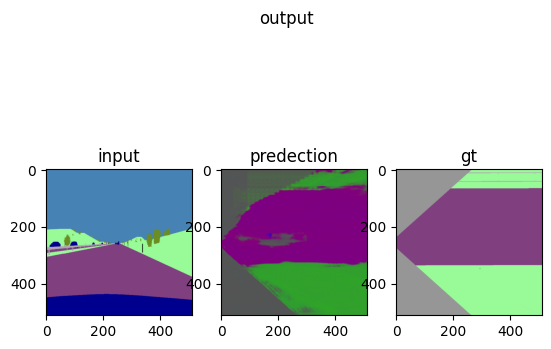

In [40]:
validation_loader = torch.utils.data.DataLoader(
    train_set, batch_size = 1, shuffle = True, num_workers = 0)
model.eval()
MAX_EPOCHS = 1
for epoch in range(MAX_EPOCHS):
    running_loss = 0.0
    torch.cuda.empty_cache()
    for input_tensor, labels in validation_loader:
        #input_tensor = input_tensor.permute(0,3,1,2)
        #labels = labels.permute(0,3,1,2)
        images = input_tensor.to(device).float()
        torch.cuda.empty_cache()
        outputs = model(images)
        break
img_draw = np.clip((outputs[0]  .squeeze(0).permute(1, 2, 0).detach().cpu().numpy() * 255),0, 255).astype(np.uint8).copy(order='C')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(input_tensor[0].permute(1,2,0))
ax1.set_title('input')
# plot the first subplot
ax2.imshow(img_draw)
ax2.set_title('predection')

# plot the second subplot
ax3.imshow(labels[0].permute(1,2,0))
ax3.set_title('gt')

# set the overall title of the figure
fig.suptitle('output')
# display the figure
plt.show()